<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Sellers/multimodal_damage_identification_preprocessing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
main_folder = "/content/drive/MyDrive/Sample_Pictures/"

In [4]:
# Preprocessing function for images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((250, 250))  # Example size, adjust accordingly
        image = np.array(image) / 255.0  # Normalize pixel values
        return np.expand_dims(image, axis=0)  # Add batch dimension (1, 250, 250, 3)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
folder = '/content/drive/MyDrive/Sample_Pictures'
images = []
for image_file in os.listdir(folder):
    if image_file.endswith(('jpg', 'jpeg', 'png')):
        image_path = os.path.join(folder, image_file)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)









In [5]:
import os

# Preprocessing function for images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((250, 250))  # Example size, adjust accordingly
        image = np.array(image) / 255.0  # Normalize pixel values
        return np.expand_dims(image, axis=0)  # Add batch dimension (1, 250, 250, 3)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

folder = '/content/drive/MyDrive/Sample_Pictures'
images = []

# Get and sort image files
image_files = sorted([file for file in os.listdir(folder) if file.endswith(('jpg', 'jpeg', 'png'))])

# Process each image
for image_file in image_files:
    image_path = os.path.join(folder, image_file)
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        images.append(processed_image)

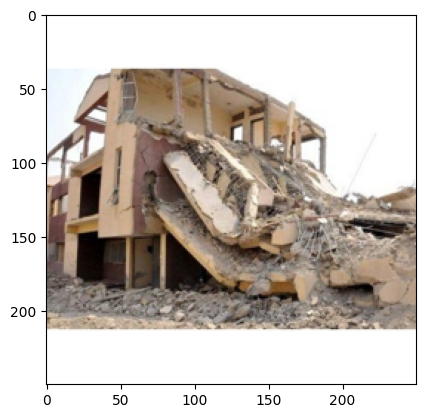

In [50]:
images[0].shape
import matplotlib.pyplot as plt
plt.imshow((images[7][0] * 255).astype('uint8'))

In [9]:
data = pd.DataFrame({'image': images})
data.head()

,image
0,"[[[[0.37254902 0.38039216 0.36862745], [0.3725..."
1,"[[[[0.10588235 0.10980392 0.1254902 ], [0.1058..."
2,"[[[[0.5254902 0.47843137 0.34509804], [0.4745..."
3,"[[[[0.75294118 0.9254902 0.99215686], [0.7686..."
4,"[[[[0.18823529 0.15686275 0.07058824], [0.2235..."


In [12]:
# Create a mapping dictionary for the indices
index_to_label = {
    0: 'flood',
    1: 'human',
    2: 'human',
    3: 'human',
    4: 'human',
    5: 'building collapse',
    6: 'building collapse',
    7: 'building collapse',
    8: 'fire',
    9: 'fire',
    10: 'building collapse',
    11: 'flood',
    12: 'drought',
    13: 'drought',
    14: 'drought',
    15: 'drought',
    16: 'flood',
    17: 'flood',
    18: 'fire',
    19: 'fire'
}

# Display the first few rows of the DataFrame to check the resultprint(data.head())
data['label'] = [index_to_label[i] for i in range(len(data))]


In [13]:
data.head(20)

,image,label
0,"[[[[0.37254902 0.38039216 0.36862745], [0.3725...",flood
1,"[[[[0.10588235 0.10980392 0.1254902 ], [0.1058...",human
2,"[[[[0.5254902 0.47843137 0.34509804], [0.4745...",human
3,"[[[[0.75294118 0.9254902 0.99215686], [0.7686...",human
4,"[[[[0.18823529 0.15686275 0.07058824], [0.2235...",human
5,"[[[[0.63137255 0.85490196 0.97254902], [0.6313...",building collapse
6,"[[[[0.91764706 0.91764706 0.91764706], [0.9176...",building collapse
7,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...",building collapse
8,"[[[[0.05490196 0.03921569 0.00392157], [0.0549...",fire
9,"[[[[0.02352941 0.00392157 0. ], [0.0313...",fire


In [57]:
X = data['image']
y = data['label']

In [60]:
X = np.array([img[0] for img in X])

In [61]:
X[0]

array([[[0.37254902, 0.38039216, 0.36862745],
        [0.37254902, 0.36862745, 0.37254902],
        [0.38431373, 0.38823529, 0.4       ],
        ...,
        [0.52941176, 0.54509804, 0.54901961],
        [0.50980392, 0.5254902 , 0.51764706],
        [0.47843137, 0.49411765, 0.49019608]],

       [[0.41960784, 0.4       , 0.4       ],
        [0.40392157, 0.37254902, 0.38431373],
        [0.41960784, 0.4       , 0.41960784],
        ...,
        [0.61568627, 0.63137255, 0.63529412],
        [0.52941176, 0.54509804, 0.54509804],
        [0.52941176, 0.54509804, 0.54117647]],

       [[0.42352941, 0.36470588, 0.36470588],
        [0.40784314, 0.3372549 , 0.35294118],
        [0.40392157, 0.35294118, 0.37647059],
        ...,
        [0.69803922, 0.71372549, 0.7254902 ],
        [0.50196078, 0.51764706, 0.5254902 ],
        [0.63529412, 0.65098039, 0.6627451 ]],

       ...,

       [[0.54117647, 0.5254902 , 0.49019608],
        [0.52941176, 0.51372549, 0.47843137],
        [0.54117647, 0

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [63]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [64]:
X_train= np.array(X_train)
X_test= np.array(X_test)

In [65]:
X_train[0].ndim

3

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np

# More aggressive data augmentation
# datagen_05 = ImageDataGenerator(
#     rotation_range=30,  # Increased rotation
#     width_shift_range=0.3,  # Increased width shift
#     height_shift_range=0.3,  # Increased height shift
#     shear_range=0.3,  # Increased shear
#     zoom_range=0.3,  # Increased zoom
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],  # Added brightness variation
#     fill_mode='nearest')

# datagen_05.fit(X_train)

# Model definition with changes
model_05 = Sequential()

model_05.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model_05.add(BatchNormalization())  # Added Batch Normalization
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.4))  # Adjusted dropout

model_05.add(Conv2D(64, (3, 3), activation='relu'))
model_05.add(BatchNormalization())  # Added Batch Normalization
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.4))  # Adjusted dropout

model_05.add(Conv2D(128, (3, 3), activation='relu'))
model_05.add(BatchNormalization())  # Added Batch Normalization
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.4))  # Adjusted dropout

model_05.add(Flatten())
model_05.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Adjusted L2
model_05.add(Dropout(0.4))  # Adjusted dropout
model_05.add(Dense(5, activation='softmax'))

# Compile the model with a lower learning rate
optimizer_05 = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model_05.compile(optimizer=optimizer_05, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
history_05 = model_05.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=16,
                    )

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.2000 - loss: 5.4448
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 7.4467
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5333 - loss: 5.0338
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 4.5037
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8000 - loss: 3.3519
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9333 - loss: 3.0243
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8000 - loss: 4.9197
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9333 - loss: 2.6538
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9333 - loss: 3.0243
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 2.5443


In [68]:
# Before evaluating, convert X_test to the appropriate data type

model_05.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.0000e+00 - loss: 4.3155


[4.315525054931641, 0.0]

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# model = Sequential()
# # Add convolutional layers
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# # Add fully connected layers
# model.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.03)))  # L2 regularization
# model.add(Dropout(0.5))  # Optional dropout for regularization
# model.add(Dense(64, activation='leaky_relu'))
# model.add(Dense(32, activation='leaky_relu'))
# # Output layer
# model.add(Dense(5, activation='softmax'))  # Use 'sigmoid' for binary classification
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
# data['label'] = data['image'].drop({
#                              'image'[0]: 'floods',
#                              'image'[1]: 'building collapse',
#                              'image'[2]: 'drought',
#                              'image'[3]: 'fire',
#                              'image'[4]: 'fire',
#                              'image'[5]: 'building collapse',
#                              'image'[6]: 'human',
#                              'image'[7]: 'fire',
#                              'image'[8]: 'drought',
#                              'image'[9]: 'flood',
#                              'image'[10]: 'flood',
#                              'image'[11]: 'fire',
#                              'image'[12]: 'building collapse',
#                              'image'[13]: 'human',
#                              'image'[14]: 'flood',
#                              'image'[15]: 'drought',
#                              'image'[16]: 'drought',
#                              'image'[17]: 'building collapse',
#                              'image'[18]: 'human',
#                              'image'[19]: 'flood',
#                              })
# data.head()

Above we are trying to add a label to each image.

We also need to refer to the index, and not the image.

#Original Preprocessing Entire Dataset

In [5]:
# import random

# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Assuming images, texts, and labels have already been populated
# # Select 5 random indices, or all indices if less than 5
# sample_size = min(5, len(images))  # Adjust sample size if population is smaller than 5
# if sample_size > 0:  # Check if there are any elements to sample from
#     random_indices = random.sample(range(len(images)), sample_size)

#     # Extract random images, texts, and labels
#     sampled_images = [images[i] for i in random_indices]
#     sampled_texts = [texts[i] for i in random_indices]
#     sampled_labels = [labels[i] for i in random_indices]

#     # Display or process the selected samples
#     for img, txt, lbl in zip(sampled_images, sampled_texts, sampled_labels):
#         print(f"Label: {lbl}")
#         print(f"Text: {txt[:100]}...")  # Print first 100 characters of the text for brevity
#         plt.imshow(img.squeeze())  # Assuming images are preprocessed as arrays
#         plt.show()
# else:
#     print("No images to sample from.") # Added message when 'images' is empty

No images to sample from.


In [7]:
# import random
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Define the path to your data directory
# data_dir = "/content/drive/MyDrive/Colab_Notebooks/Project_03/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

# # Loop through subfolders (assuming each subfolder represents a class/label)
# for label in os.listdir(data_dir):
#     label_dir = os.path.join(data_dir, label)
#     if os.path.isdir(label_dir):
#         # Loop through files in the subfolder
#         for filename in os.listdir(label_dir):
#             file_path = os.path.join(label_dir, filename)

#             # Check if it's an image file
#             if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 try:
#                     # Load the image
#                     img = Image.open(file_path)
#                     img = img.convert("RGB") # Convert to RGB if necessary
#                     images.append(img)
#                     labels.append(label) # Assign label based on subfolder

#                     # Assume text file has same name but with .txt extension
#                     text_file_path = file_path.replace(os.path.splitext(filename)[1], '.txt')
#                     if os.path.exists(text_file_path):
#                         with open(text_file_path, 'r') as f:
#                             text = f.read()
#                             texts.append(text)
#                     else:
#                         texts.append("") # Use empty string if no text file found

#                 except IOError:
#                     print(f"Error loading image: {file_path}")

In [9]:
# import random
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Define the path to your data directory
# data_dir = "/content/drive/MyDrive/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

# # ... (Data loading logic from previous response) ...


# # Select 5 random indices, or all indices if less than 5
# sample_size = min(5, len(images))
# if sample_size > 0:
#     random_indices = random.sample(range(len(images)), sample_size)

#     # Extract random images, texts, and labels
#     sampled_images = [images[i] for i in random_indices]
#     sampled_texts = [texts[i] for i in random_indices]
#     sampled_labels = [labels[i] for i in random_indices]

#     # Display the selected samples using Matplotlib
#     fig, axes = plt.subplots(1, sample_size, figsize=(15, 5)) # Create subplots for each image

#     for i, (img, txt, lbl) in enumerate(zip(sampled_images, sampled_texts, sampled_labels)):
#         axes[i].imshow(img)  # Display image in the corresponding subplot
#         axes[i].set_title(f"Label: {lbl}\nText: {txt[:50]}...")  # Set title with label and text snippet
#         axes[i].axis("off")  # Turn off axis ticks and labels

#     plt.tight_layout() # Adjust spacing between subplots
#     plt.show()

# else:
#     print("No images to sample from.")

No images to sample from.


In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from PIL import Image
# # Assuming 'df' is your DataFrame
# specific_row = df.iloc[0]  # Select the first row as an example
# # Access the image data from the selected row
# image_data = specific_row['image']
# # Display the image if it's in a recognizable format
# if isinstance(image_data, np.ndarray):
#     # Squeeze the image data to remove the extra dimension
#     image_data = np.squeeze(image_data)  # This removes dimensions of size 1
#     plt.imshow(image_data)
#     plt.show()
# elif isinstance(image_data, Image.Image):
#     image_data.show()
# else:
#     print("Image data is not in a recognizable format.")

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((640, 640))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((640, 640))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# images = np.array([np.array(image) for image in images])
# type(images)

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                    })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',

#                                    })